# CIFAR-10: Download & Load (Raw Format)

This notebook downloads the **raw CIFAR-10 (python version)**, extracts it, loads batches with pure Python/NumPy, and shows a sample image with its class name.


In [1]:
# --- Step 1: Download (original source) ---
# If this cell fails due to network restrictions in your environment,
# you can manually download the file and place it next to this notebook.
# CHANGE THE LINE BELOW TO YOUR WORKING DIRECTORY (ROOT DIRECTORY OF YOUR PROJECT)
%cd /workspaces/cosc470 

!wget -O cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Now extract the resulting tar.gz archive
!tar -xzvf cifar-10-python.tar.gz -C ./data

# The files will be in /workspaces/cosc470/data/cifar-10-batches-py/
!ls -l ./data/cifar-10-batches-py/ | head -n 15


/workspaces/cosc470
--2025-09-16 22:27:06--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  45.7MB/s    in 4.1s    

2025-09-16 22:27:11 (39.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
total 181876
-rw-r--r-- 1 codespace codespace      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 codespace codespace 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 code

In [5]:
# --- Step 3: Loader utilities (no Keras/torchvision) ---
import pickle
import numpy as np
import os

def load_cifar_batch(filename):
    """Load a single CIFAR-10 batch file and return (data, labels, filenames).
    - data: (N, 32, 32, 3) uint8
    - labels: (N,) int
    - filenames: list of N strings
    """
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')  # needed for python3
    flat = batch['data']            # shape (10000, 3072)
    labels = batch.get('labels', batch.get('fine_labels'))  # fallback for CIFAR-100 style keys
    filenames = batch.get('filenames', None)
    
    # reshape to (N, 32, 32, 3) from channel-major flat (R 1024, G 1024, B 1024)
    data = flat.reshape(len(flat), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, flat, np.array(labels), filenames

def load_cifar_meta(root):
    """Load label names (class names) from batches.meta."""
    meta_path = os.path.join(root, 'batches.meta')
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    # For CIFAR-10, 'label_names' is a list of 10 class names
    label_names = meta.get('label_names', None)
    return label_names

def load_cifar10(root='cifar-10-batches-py'):
    """Load entire CIFAR-10 (train + test). Returns:
        (X_train, flat_training, y_train, X_test, flat_test, y_test, class_names)
    Where:
        - X_* : (N, 32, 32, 3) uint8
        - y_* : (N,) int (0..9)
        - class_names: list of 10 strings
    """
    train_data, flat_data, train_labels = [], [], []
    for i in range(1, 6):
        data, flat, labels, _ = load_cifar_batch(os.path.join(root, f'data_batch_{i}'))
        train_data.append(data)
        flat_data.append(flat)  
        train_labels.append(labels)
    X_train = np.concatenate(train_data, axis=0)
    X_flat = np.concatenate(flat_data, axis=0)
    y_train = np.concatenate(train_labels, axis=0)

    X_test, X_test_flat, y_test, _ = load_cifar_batch(os.path.join(root, 'test_batch'))
    class_names = load_cifar_meta(root)

    num_classes = 10
    flat_training = [
        (X_flat[i].astype(np.float32).reshape(3072, 1) / 255.0, np.eye(num_classes)[y_train[i]].reshape(num_classes, 1))
        for i in range(X_flat.shape[0])
    ]
    flat_test = [
        (X_test_flat[i].astype(np.float32).reshape(3072, 1) / 255.0, y_test[i])
        for i in range(X_test_flat.shape[0])
    ]

    return X_train, flat_training, y_train, X_test, flat_test, y_test, class_names


In [3]:
# --- Step 4: Load all data ---
%cd /workspaces/cosc470
X_train, flat_training, y_train, X_test, flat_test, y_test, class_names = load_cifar10('./data/cifar-10-batches-py')
flat_training = list(flat_training)
flat_test = list(flat_test)
print('Train:', X_train.shape, len(flat_training), y_train.shape, X_train.dtype)
print('Test :', X_test.shape, len(flat_test), y_test.shape, X_test.dtype)
print('Classes:', class_names)
print(y_train[0], class_names[y_train[0]] if class_names else '')



/workspaces/cosc470
Train: (50000, 32, 32, 3) 50000 (50000,) uint8
Test : (10000, 32, 32, 3) 10000 (10000,) uint8
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
6 frog


[[0.23137255]
 [0.16862746]
 [0.19607843]
 ...
 [0.54901963]
 [0.32941177]
 [0.28235295]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


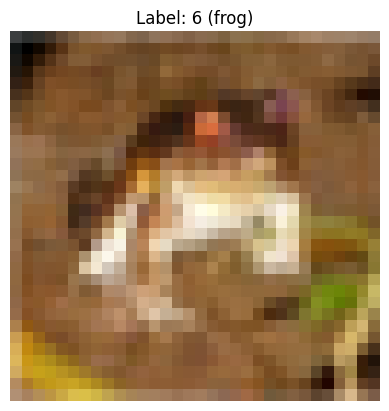

In [6]:
# --- Step 5: Visualize one sample ---
import matplotlib.pyplot as plt

idx = 0  # try different numbers to preview other images
img = X_train[idx]
flat = flat_training[idx]
label = y_train[idx]
name = class_names[label] if class_names else str(label)

# need to reshape, normalize to [0,1] for training in our NN later
print(flat[0])
print(flat[1])
plt.imshow(img)
plt.title(f'Label: {label} ({name})')
plt.axis('off')
plt.show()


In [7]:
%cd /workspaces/cosc470/nn 

import network2
import time

# --- PART 3: Construct and train the simple NN below on CIFAR-10 ---
# Note: This is a slightly larger version of MNIST a demo. The accuracy will be low.
# You can improve it by tuning hyperparameters, using data augmentation, etc.
net = network2.Network([3072, 100, 10], cost=network2.CrossEntropyCost)

# Train the neural network  (experiment with the hyperparameters)
start = time.time()
(_, acc, _, _) = net.SGD(flat_training, 10, 10, 0.1, evaluation_data=flat_test, monitor_evaluation_accuracy=True)
# write down the final accuracy which is acc['9']
print("Training time for 3072-100-10 config: ")
print(time.time() - start)

# Measure evaluation time
eval_start = time.time()
for x, y in flat_test:
    net.feedforward(x)
print("Evaluation time for the 3072-100-10 config: ")
print(time.time() - eval_start)

/workspaces/cosc470/nn
Epoch 0 training complete
Accuracy on evaluation data: 3456 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 4008 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 4002 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 4405 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 4137 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 3953 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 4235 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 3792 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 4127 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 3888 / 10000
Training time for 3072-100-10 config: 
359.45338916778564
Evaluation time for the 3072-100-10 config: 
0.6704368591308594


In [11]:
# --- PART 4: Evaluate several configurations below ---

configlabels = ["3072-100-10", "3072-50-10", "3072-500-10", "3072-100-100-10"]
configs = [([3072, 100, 10],0.1), ([3072, 50, 10],0.2), ([3072, 500, 10],0.05), ([3072, 100, 100, 10],0.01)]
accuracies = [] 
tt = [] 
et = [] 

for i in range(len(configs)):
    net = network2.Network(configs[i][0], cost=network2.CrossEntropyCost)

    start = time.time()
    (_, acc, _, _) = net.SGD(flat_training, 10, 10, configs[i][1], evaluation_data=flat_test, monitor_evaluation_accuracy=True)
    accuracies.append(acc[9])
    tt.append(time.time() - start)
    print("Training time for " + configlabels[i] + " config: ")
    print(time.time() - start)

    # Measure evaluation time
    eval_start = time.time()
    for x, y in flat_test:
        net.feedforward(x)
    et.append(time.time() - eval_start)
    print("Evaluation time for " + configlabels[i] + " config: ")
    print(time.time() - eval_start)

Epoch 0 training complete
Accuracy on evaluation data: 3701 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 3950 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 3614 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 4035 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 4163 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 3883 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 3983 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 4101 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 3689 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 4177 / 10000
Training time for 3072-100-10 config: 
344.7978677749634
Evaluation time for 3072-100-10 config: 
0.5156402587890625
Epoch 0 training complete
Accuracy on evaluation data: 2225 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 2904 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 3167 / 10000

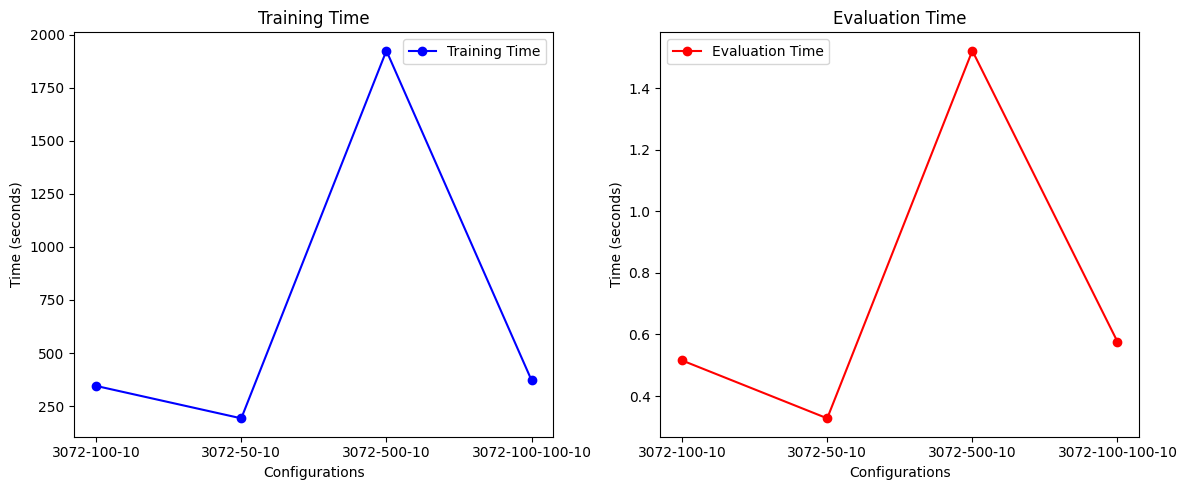

In [ ]:
# --- PART 4: add a matplotlib showing all the results from the previous cell

##DATA____

#Training time for 3072-100-10 config: 
#344.7978677749634
#Evaluation time for 3072-100-10 config: 
#0.5156402587890625

#--------------------------------------------#

#Training time for 3072-50-10 config: 
#192.02195763587952
#Evaluation time for 3072-50-10 config: 
#0.32765865325927734

#--------------------------------------------#

#Training time for 3072-500-10 config: 
#1924.973091840744
#Evaluation time for 3072-500-10 config: 
#1.5214972496032715

#--------------------------------------------#

#Training time for 3072-100-100-10 config: 
#371.8558576107025
#Evaluation time for 3072-100-100-10 config: 
#0.5766916275024414


##PLOTTING____
import matplotlib.pyplot as plt

configs = ['3072-100-10', '3072-50-10', '3072-500-10', '3072-100-100-10']
tt = [344.7978677749634, 192.02195763587952, 1924.973091840744, 371.8558576107025]
et = [0.5156402587890625, 0.32765865325927734, 1.5214972496032715, 0.5766916275024414]
x = range(len(configs))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Training Time plot
axs[0].plot(x, tt, label='Training Time', color='b', marker='o')
axs[0].set_xlabel('Configurations')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('Training Time')
axs[0].set_xticks(x)
axs[0].set_xticklabels(configs)
axs[0].legend()

# Evaluation Time plot
axs[1].plot(x, et, label='Evaluation Time', color='r', marker='o')
axs[1].set_xlabel('Configurations')
axs[1].set_ylabel('Time (seconds)')
axs[1].set_title('Evaluation Time')
axs[1].set_xticks(x)
axs[1].set_xticklabels(configs)
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
##ANSWER____

#It seems that the single hidden layer network is more efficient than the double hidden layer. Not by much but there's a difference of about 27 seconds of training time for each
# epoch. That adds up to a lot of time over 10 epochs. The evaluation time is also slightly better for the single hidden layer network. Overall, the single hidden layer network seems 
# to be the better choice for this task. If we varied the number of hidden neurons in the first hidden layer vs the second hidden layer( say 300 in first and 80 in the second) maybe we
# could get the double hidden layer neural network to be more efficient.